# Deep Learning for Sentiment Analysis, LSTM

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Load Datasets

In [3]:
with open('datasets/reviews.txt', 'r') as f: reviews = f.readlines()

In [4]:
with open('datasets/labels.txt', 'r') as f: labels = f.readlines()

## Preprocess Datasets

#### 1) Removing punctuations

In [5]:
from string import punctuation

In [6]:
def get_words(corpus):
    
    cleaned_reviews = list()

    for text in reviews:
        text = text.lower()
        text = ''.join([char for char in text if char not in punctuation])

        cleaned_reviews.append(text)

    words = ' '.join(cleaned_reviews).split()

    return words, cleaned_reviews

In [7]:
words, cleaned_reviews = get_words(reviews)

#### 2) Counting all the words and sort it based on counts

In [8]:
from collections import Counter 

In [9]:
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)

print('Top 5-occuring words:')
print(sorted_words[:5])

Top 5-occuring words:
[('the', 336713), ('and', 164107), ('a', 163009), ('of', 145864), ('to', 135720)]


#### 3) Creating a dictionary and encoding the corresponding words

In [10]:
word2index = { w:i+1 for i, (w,c) in enumerate(sorted_words) }

In [11]:
encoded_reviews = list()

for review in cleaned_reviews:
    
    encoded_review = list()
    for word in review.split():
        if word not in word2index.keys():
            # if word is not available in word2index put 0 in that place
            encoded_review.append(0)
        else:
            encoded_review.append(word2index[word])
    
    encoded_reviews.append(encoded_review)

In [12]:
# making encoded review in the same length
sequence_length = 250

features = np.zeros((len(encoded_reviews), sequence_length), dtype=int)
for i, review in enumerate(encoded_reviews):
    
    review_len = len(review)
    if (review_len <= sequence_length):
        zeros = list(np.zeros(sequence_length-review_len))
        new = zeros + review
    else:
        new = review[:sequence_length]
    
    features[i,:] = np.array(new)

#### 4) One-hot-encoding labels

In [13]:
labels = [1 if label.strip() == 'positive' else 0 for label in labels]

## Build Data Loader

#### 1) Splitting dataset into training, valid and test dataset

In [14]:
train_size, valid_size, test_size = 0.8, 0.1, 0.1

In [15]:
X_train = features[:int(train_size * len(features))]
y_train = labels[:int(train_size * len(features))]

X_valid = features[int(train_size * len(features)):int( (train_size+valid_size) * len(features))]
y_valid = labels[int(train_size * len(features)):int( (train_size+valid_size) * len(features))]

X_test = features[int( (train_size+valid_size) * len(features)):]
y_test = labels[int( (train_size+valid_size) * len(features)):]

#### 2) Creating Tensor Dataset

In [16]:
train_data = TensorDataset(torch.LongTensor(X_train), torch.FloatTensor(y_train))
valid_data = TensorDataset(torch.LongTensor(X_valid), torch.FloatTensor(y_valid))
test_data = TensorDataset(torch.LongTensor(X_test), torch.FloatTensor(y_test))

#### 3) Creating Data Loader

In [17]:
BATCH_SIZE = 50

In [18]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
# obtaining one batch of training data
data_iter = iter(train_loader)
X_sample, y_sample = data_iter.next()

print('Sample input size:', X_sample.size())
print('Sample label size:', y_sample.size())

Sample input size: torch.Size([50, 250])
Sample label size: torch.Size([50])


## Build LSTM Network

In [20]:
VOCAB_SIZE = len(word2index)+1
OUTPUT_SIZE = 1
EMBEDDING_DIM = 400
HIDDEN_DIM = 256
N_LAYERS = 2

LR = 0.001
N_EPOCHS = 5

In [21]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [22]:
class SentimentalLSTM(nn.Module):
    """
    The LSTM-based model that will be used to perform sentiment analysis task.
    """
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentalLSTM, self).__init__()
        
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # create model layers
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1_layer = nn.Linear(hidden_dim, 64)
        self.fc2_layer = nn.Linear(64, 16)
        self.fc3_layer = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def init_hidden(self, batch_size, device):
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        
        return hidden
        
    def forward(self, x, hidden):
        
        batch_size = x.size()
        
        embeds = self.embedding_layer(x)
        lstm_out, hidden = self.lstm_layer(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # stack up the lstm output
        
        # layers act as classifier
        output = self.dropout(lstm_out)
        output = self.fc1_layer(output)
        
        output = self.dropout(output)
        output = self.fc2_layer(output)
        
        output = self.dropout(output)
        output = self.fc3_layer(output)
        output = self.sigmoid(output)
        
        output = output.view(batch_size, -1)
        output = output[:, -1]
        
        return output, hidden

#### Initialize Sentimental LSTM Model

In [23]:
lstm_net = SentimentalLSTM(VOCAB_SIZE, OUTPUT_SIZE, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS)
lstm_net.to(device)

SentimentalLSTM(
  (embedding_layer): Embedding(74073, 400)
  (lstm_layer): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1_layer): Linear(in_features=256, out_features=64, bias=True)
  (fc2_layer): Linear(in_features=64, out_features=16, bias=True)
  (fc3_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Set Loss Function

In [24]:
bce_loss = nn.BCELoss()

## Set Optimizer

In [25]:
optimizer = torch.optim.Adam(lstm_net.parameters(), lr=LR)

## Train The Network

In [26]:
counter = 0
print_every = 100
clip = 5

In [27]:
train_losses = []

lstm_net.train()
for epoch in range(1, N_EPOCHS+1):
    
    hidden = lstm_net.init_hidden(BATCH_SIZE, device)
    
    for inputs, labels in train_loader:
        counter += 1
        
        hidden = tuple([each.data for each in hidden])
        
        inputs, labels = inputs.to(device), labels.to(device)
                
        optimizer.zero_grad()
        lstm_out, hidden = lstm_net(inputs, hidden)
        loss = bce_loss(lstm_out.squeeze(), labels.float())
        
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_net.parameters(), clip)
        optimizer.step()
        
        if counter % print_every == 0:
            
            valid_hidden = lstm_net.init_hidden(BATCH_SIZE, device)
            valid_losses = []
            
            lstm_net.eval()
            for inputs, labels in valid_loader:
                
                valid_hidden = tuple([each.data for each in valid_hidden])
                
                inputs, labels = inputs.to(device), labels.to(device)
                lstm_out, valid_hidden = lstm_net(inputs, valid_hidden)
                valid_loss = bce_loss(lstm_out.squeeze(), labels.float())
                
                valid_losses.append(valid_loss.item())
                
            lstm_net.train()
            print(f'Epoch: {epoch}/{N_EPOCHS}...',
                  f'Step: {counter}...',
                  f'Loss: {loss.item():.6f}...',
                  f'Valid Loss: {np.mean(valid_losses):.6f}')
            
            train_losses.append(loss.item())

Epoch: 1/5... Step: 100... Loss: 0.695936... Valid Loss: 0.652171
Epoch: 1/5... Step: 200... Loss: 0.653189... Valid Loss: 0.635135
Epoch: 1/5... Step: 300... Loss: 0.595953... Valid Loss: 0.591437
Epoch: 1/5... Step: 400... Loss: 0.522252... Valid Loss: 0.539861
Epoch: 2/5... Step: 500... Loss: 0.424537... Valid Loss: 0.545904
Epoch: 2/5... Step: 600... Loss: 0.367605... Valid Loss: 0.532339
Epoch: 2/5... Step: 700... Loss: 0.467702... Valid Loss: 0.503054
Epoch: 2/5... Step: 800... Loss: 0.616933... Valid Loss: 0.531863
Epoch: 3/5... Step: 900... Loss: 0.409398... Valid Loss: 0.499556
Epoch: 3/5... Step: 1000... Loss: 0.272488... Valid Loss: 0.596831
Epoch: 3/5... Step: 1100... Loss: 0.481810... Valid Loss: 0.417055
Epoch: 3/5... Step: 1200... Loss: 0.334764... Valid Loss: 0.426923
Epoch: 4/5... Step: 1300... Loss: 0.192200... Valid Loss: 0.451102
Epoch: 4/5... Step: 1400... Loss: 0.420731... Valid Loss: 0.561896
Epoch: 4/5... Step: 1500... Loss: 0.357495... Valid Loss: 0.504912
Epoc

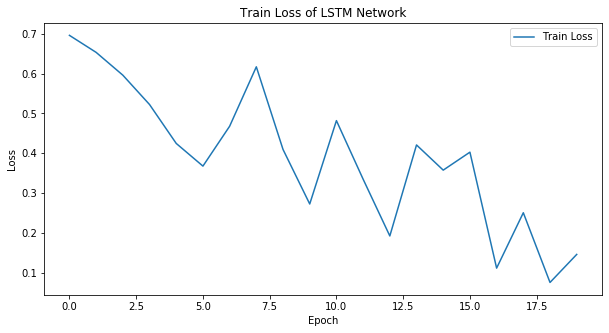

In [33]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of LSTM Network")
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/LSTM_final_train_loss.png')
plt.show()

## Test The Network

In [29]:
test_losses = []
num_correct = 0

# init hidden state
hidden = lstm_net.init_hidden(BATCH_SIZE, device)

lstm_net.eval()
for inputs, labels in test_loader:
    
    hidden = tuple([each.data for each in hidden])
    
    inputs, labels = inputs.to(device), labels.to(device)
    lstm_out, hidden = lstm_net(inputs, hidden)
    
    # calculate loss
    test_loss = bce_loss(lstm_out.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class whether positive or negative
    prediction = torch.round(lstm_out.squeeze())
    correct_tensor = prediction.eq(labels.float().view_as(prediction))
    
    if device.type == 'cpu': correct = np.squeeze(correct_tensor.numpy())
    else: correct = np.squeeze(correct_tensor.cpu().numpy())
    
    num_correct += np.sum(correct)

In [30]:
print(f'Test Loss: {np.mean(test_losses):.6f}')

test_accuracy = num_correct/ len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Loss: 0.457503
Test Accuracy: 80.48%


---